# Determining Starbucks Demographics

In this notebook I will use the data cleaning performed in the processing notebook to attempt to determine what the core demographics of starbucks memebership are in a effort to see how targeted marketing could be implemented efficently in future on consumers. 

This process will involve running an unsupervised learning method to cluster the data into groups based on information provided in their profiles including age, gender, income and length of membership. It will also take into account how much users normally spend at starbucks on a per transaction basis.

First, I will perform some further processing of the data to prepare it for the model (standard scalars etc.). Then I will run a K-means ml model to cluster the data and determine what the optimimun number of clusters describes the demographics appropriately. After this I will describe some interesting findings from the results to gain data understanding before the final step of this projetct in Part 2 (Modelling the prices for each demographic and seeing how they have performed for each marketing campagin. 

### Imports

In [1]:
# import general functions
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

# import functions for modelling
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Saving the ML model
import joblib

# import the cleaning package
import sbpkg as sb

### Functions

### Global Variables

In [2]:
# read in the different datasources
portfolio_df = pd.read_json('data/portfolio.json', lines=True)
profile_df = pd.read_json('data/profile.json', lines=True)
transcript_df = pd.read_json('data/transcript.json', lines=True)

### Run Cleaning Functions

In [3]:
# run the initial cleaning on each dataset
clean_port_df = sb.clean_portfolio_data(portfolio_df)
clean_prof_df = sb.clean_profile_data(profile_df)
clean_trans_df = sb.clean_transcript_data(transcript_df)

# calculates the uninfluenced transactions for the modeling
uninflunced_trans = sb.norm_transactions(clean_trans_df, clean_port_df)

# process the user data to create the modeling input
user_data = sb.user_transactions(clean_prof_df, uninflunced_trans)
user_data.head()

,female,male,other,unknown gender,age,member joined,person,income,total transactions,total spend,spend per trans,spend per day,membership length
0,0,0,0,1,0,2017-02-12,68be06ca386d4c31939f3a4f0e3dd783,0.0,9,20.40,2.266667,0.680000,76.0
1,1,0,0,0,55,2017-07-15,0610b486422d4921ae7d2bf64640c50b,112000.0,3,77.01,25.670000,2.567000,54.0
2,0,0,0,1,0,2018-07-12,38fe809add3b4fcf9315a9694bb96ff5,0.0,5,10.21,2.042000,0.340333,2.0
3,1,0,0,0,75,2017-05-09,78afa995795e4d85b5d9ceeca43f5fef,100000.0,4,89.99,22.497500,2.999667,63.0
4,0,0,0,1,0,2017-08-04,a03223e636434f42ac4c3df47e8bac43,0.0,3,4.65,1.550000,0.155000,51.0


### Demographics Modelling

In [4]:
user_data.columns

Index(['female', 'male', 'other', 'unknown gender', 'age', 'member joined',
       'person', 'income', 'total transactions', 'total spend',
       'spend per trans', 'spend per day', 'membership length'],
      dtype='object')

In [5]:
# remove unwanted columns
demographics_input = user_data.drop(columns=['member joined','person', 'total transactions', 'total spend'])

In [6]:
# Apply feature scaling to the demographics data.
scaler = StandardScaler()
scaler.fit(demographics_input)
input_demo_data = scaler.transform(demographics_input)

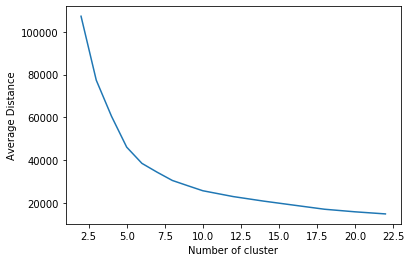

In [7]:
# run k-means over different cluster counts to see the best number of groups to split our demographic data into
ad = {}
cluster_counts = [2,3,4,5,6,7,8,9,10,12,14,16,18,20,22]
for x in cluster_counts:
    kmeans = KMeans(n_clusters=x, max_iter=1000).fit(input_demo_data)
    ad[x] = kmeans.inertia_
plt.plot(list(ad.keys()), list(ad.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Average Distance")
plt.show()

In [8]:
# create and run the model
final_kmeans = KMeans(n_clusters=8, max_iter=1000).fit(input_demo_data)
predict = final_kmeans.predict(input_demo_data)

# add the pedictions for the clustering onto the original dataset
demographics_output = demographics_input
demographics_output['cluster'] = predict

### Demographics Analysis

In [9]:
demographics_output.groupby('cluster').mean()

,female,male,other,unknown gender,age,income,spend per trans,spend per day,membership length
cluster,,,,,,,,,
0,0.000000,1.000000,0.0,0.0,60.444397,81426.005133,22.092649,4.466201,75.070145
1,1.000000,0.000000,0.0,0.0,63.564690,86695.080863,23.028409,4.321730,87.980458
2,0.000000,0.000000,0.0,1.0,0.000000,0.000000,2.352779,0.452499,70.869565
3,0.502793,0.497207,0.0,0.0,56.983240,79050.279330,129.113700,25.947760,81.608939
4,0.000000,0.000000,1.0,0.0,54.507614,62649.746193,14.529618,3.232132,71.472081
5,0.000000,1.000000,0.0,0.0,47.616538,50965.775668,5.885533,1.084990,35.041469
6,0.032294,0.967706,0.0,0.0,49.905902,54699.331849,7.968539,1.945205,178.811804
7,1.000000,0.000000,0.0,0.0,50.883890,54023.584906,10.248875,2.027721,56.779753


In [10]:
demographics_output.groupby('cluster')['age'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,2338.0,60.444397,13.991031,18.0,52.0,60.0,70.0,100.0
1,2968.0,63.564690,13.608563,19.0,54.0,62.0,73.0,101.0
2,2070.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
3,179.0,56.983240,16.848124,18.0,46.5,58.0,67.5,97.0
4,197.0,54.507614,16.537101,20.0,43.0,55.0,67.0,100.0
5,4003.0,47.616538,17.498671,18.0,33.0,47.0,61.0,98.0
6,1796.0,49.905902,17.555310,18.0,37.0,50.0,63.0,98.0
7,2756.0,50.883890,17.717370,18.0,37.0,51.0,63.0,101.0


### Output the demographics model

In [11]:
joblib.dump(final_kmeans, 'kmeans_demographic_model.pkl')

['kmeans_demographic_model.pkl']

In [12]:
# Create a function below to read in the model and predict the demographic for other datasets
def predict_demographic(profile_data, demographic_model='kmeans_demographic_model.pkl'):
    """
    this can be used to predict the demographics of group of consumers
    """
    # Reads the volume model 
    final_kmeans = joblib.load(demographic_model)
    
    # remove unwanted columns
    profile_data_input = profile_data.drop(columns=['member joined',
                                              'person', 
                                              'total transactions', 
                                              'total spend'])
    
    # process the profile data
    scaler = StandardScaler()
    scaler.fit(profile_data_input)
    input_demo_data = scaler.transform(profile_data_input)
    
    # predict the demographics   
    predictions = final_kmeans.predict(input_demo_data)
    
    # add the pedictions for the clustering onto the original dataset
    updated_dataframe = profile_data
    updated_dataframe['demographic'] = predictions
    
    return updated_dataframe